In [1]:
from src.dataloader import ImageDataset
from src.model import Classifier,Config,CNNFeatureExtractor,ClassicalFeatureExtractor,load
from src.trainer import RealWasteTrainer
from torch.utils.data import random_split,Subset
import torch
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
config = Config()
BATCH_SIZE = 32
ROOT_DATA_PATH = './dataset'
SEED = 42
EPOCHS = 20

In [3]:
config.conv_hidden_dim=6
config.fc_hidden_dim=1

In [4]:
dataset = ImageDataset(ROOT_DATA_PATH,config.img_size)

In [5]:
labels = [item['id'] for item in dataset.data]

In [6]:
# Stratified Sampling for train and val
train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.2,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=labels)

# Subset dataset for train and val
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, validation_idx)

In [7]:
print(train_dataset.dataset.classes)
print(val_dataset.dataset.classes)

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
backbone = CNNFeatureExtractor(config).to(device)
cnnmodel = Classifier(backbone,train_dataset.dataset.classes,config).to(device)

In [10]:
trainer = RealWasteTrainer(cnnmodel,train_dataset.dataset,val_dataset.dataset,batch_size=BATCH_SIZE,lr=1e-3,device=device)

In [11]:
start_time = time.time()

Epoch 1 Train Loss: 2.0696 | Train Acc : 0.2296 | Val Loss : 1.8268 | Val Acc : 0.3188


Epoch 2 Train Loss: 1.6468 | Train Acc : 0.3956 | Val Loss : 1.4265 | Val Acc : 0.4851


Epoch 3 Train Loss: 1.3667 | Train Acc : 0.4922 | Val Loss : 1.2377 | Val Acc : 0.5356


Epoch 4 Train Loss: 1.1987 | Train Acc : 0.5614 | Val Loss : 1.0269 | Val Acc : 0.6208


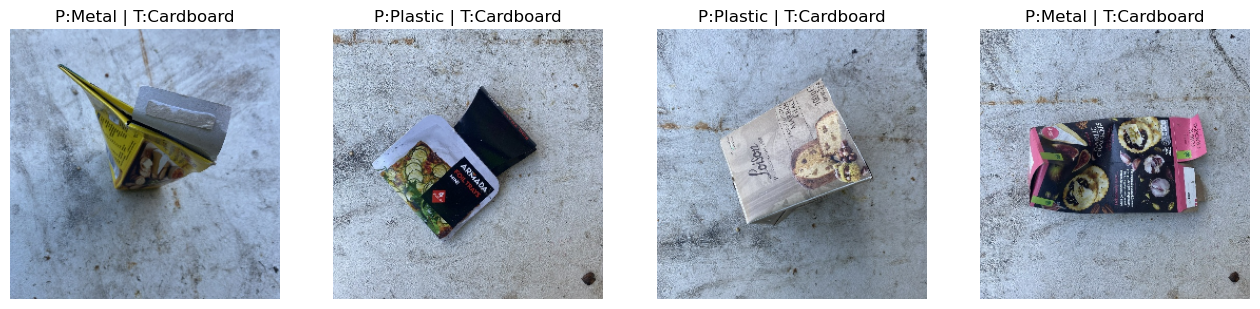

Epoch 5 Train Loss: 1.0594 | Train Acc : 0.6105 | Val Loss : 0.8932 | Val Acc : 0.6730


Epoch 6 Train Loss: 0.9274 | Train Acc : 0.6555 | Val Loss : 0.7753 | Val Acc : 0.7212


Epoch 7 Train Loss: 0.8095 | Train Acc : 0.6923 | Val Loss : 0.7109 | Val Acc : 0.7342


Epoch 8 Train Loss: 0.7412 | Train Acc : 0.7285 | Val Loss : 0.6508 | Val Acc : 0.7725


Epoch 9 Train Loss: 0.6495 | Train Acc : 0.7614 | Val Loss : 0.5051 | Val Acc : 0.8218


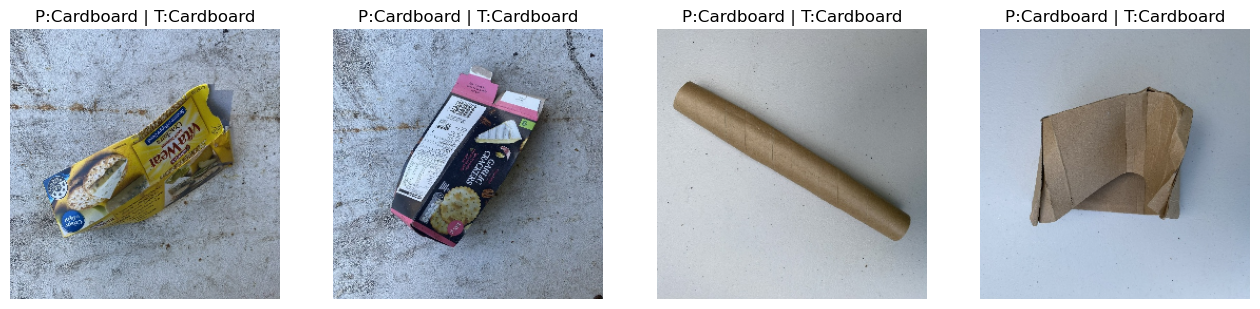

Epoch 10 Train Loss: 0.5612 | Train Acc : 0.7925 | Val Loss : 0.4890 | Val Acc : 0.8190


Epoch 11 Train Loss: 0.4684 | Train Acc : 0.8253 | Val Loss : 0.3229 | Val Acc : 0.8899


Epoch 12 Train Loss: 0.4212 | Train Acc : 0.8516 | Val Loss : 0.4097 | Val Acc : 0.8493


Epoch 13 Train Loss: 0.3648 | Train Acc : 0.8655 | Val Loss : 0.3110 | Val Acc : 0.8912


Epoch 14 Train Loss: 0.3077 | Train Acc : 0.8904 | Val Loss : 0.2281 | Val Acc : 0.9249


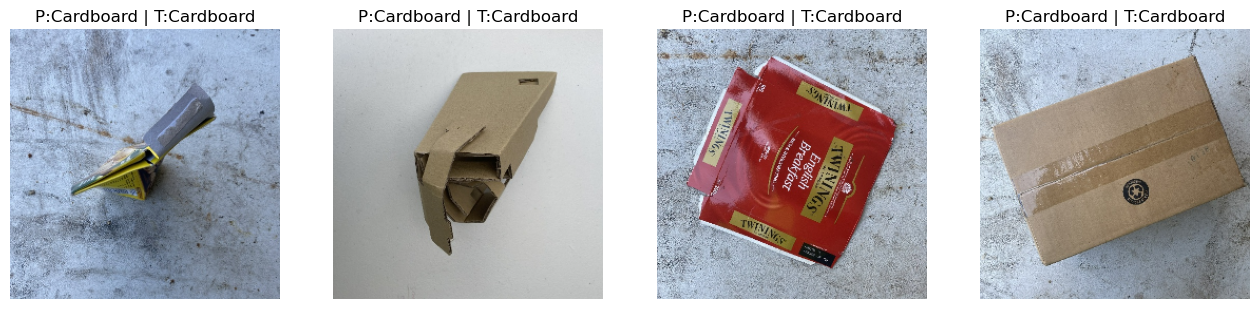

Epoch 15 Train Loss: 0.2461 | Train Acc : 0.9122 | Val Loss : 0.1317 | Val Acc : 0.9575


Epoch 16 Train Loss: 0.2263 | Train Acc : 0.9177 | Val Loss : 0.1575 | Val Acc : 0.9491


Epoch 17 Train Loss: 0.1925 | Train Acc : 0.9318 | Val Loss : 0.1131 | Val Acc : 0.9674


Epoch 18 Train Loss: 0.1763 | Train Acc : 0.9377 | Val Loss : 0.0908 | Val Acc : 0.9712


Epoch 19 Train Loss: 0.1367 | Train Acc : 0.9543 | Val Loss : 0.0664 | Val Acc : 0.9762


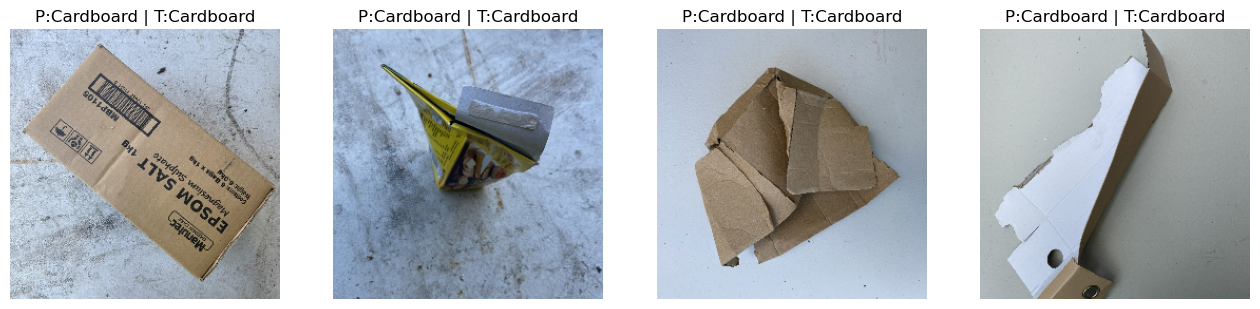

Epoch 20 Train Loss: 0.1426 | Train Acc : 0.9482 | Val Loss : 0.1233 | Val Acc : 0.9560


In [12]:
train_loss,train_acc,val_loss,val_acc = trainer.train(epochs=EPOCHS,visualize_every=5)

In [13]:
dt = time.time()-start_time
print(f"Training took {dt} seconds")

Training took 543.3376474380493 seconds


In [14]:
cnnmodel.save(os.path.join('trained_model','cnn_model.pt'))

Model saved to trained_model\cnn_model.pt


In [15]:
def plot(datas,labels,xlabel,ylabel,title,figsize=(16,8)):
    plt.figure(figsize=figsize)
    for data,label in zip(datas,labels):
        plt.plot(range(1, len(data)+1), data, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

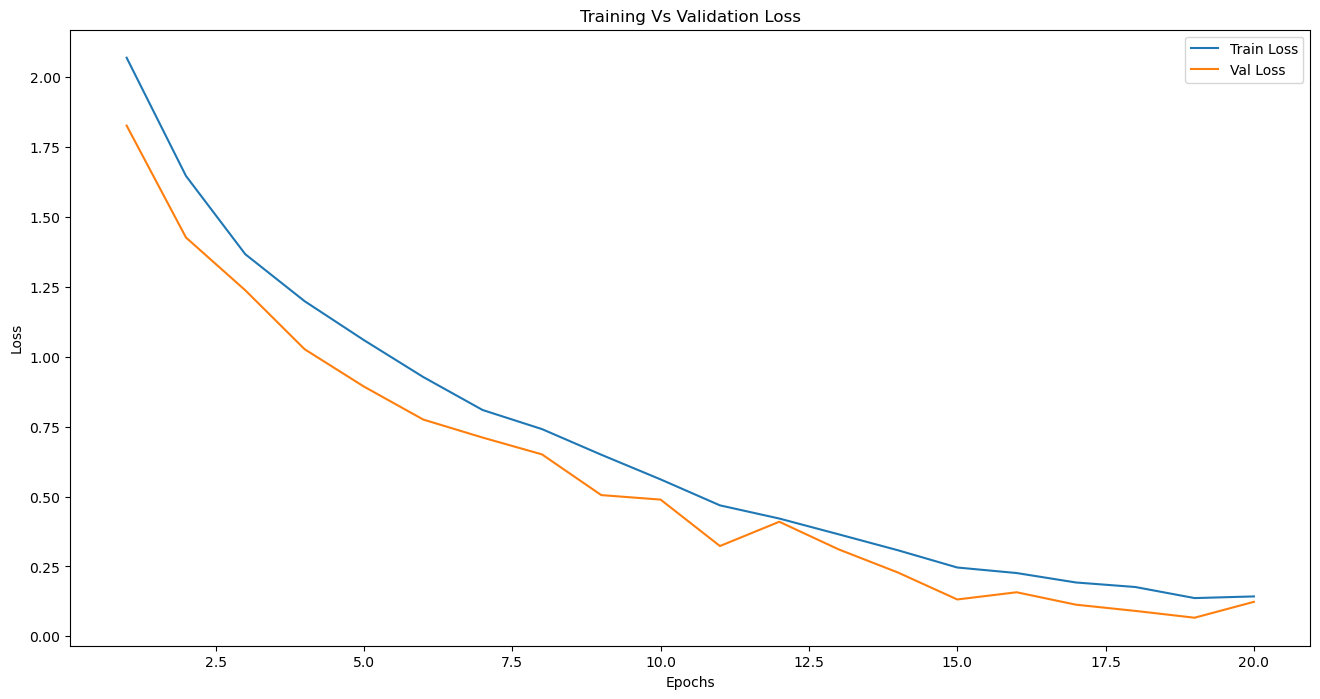

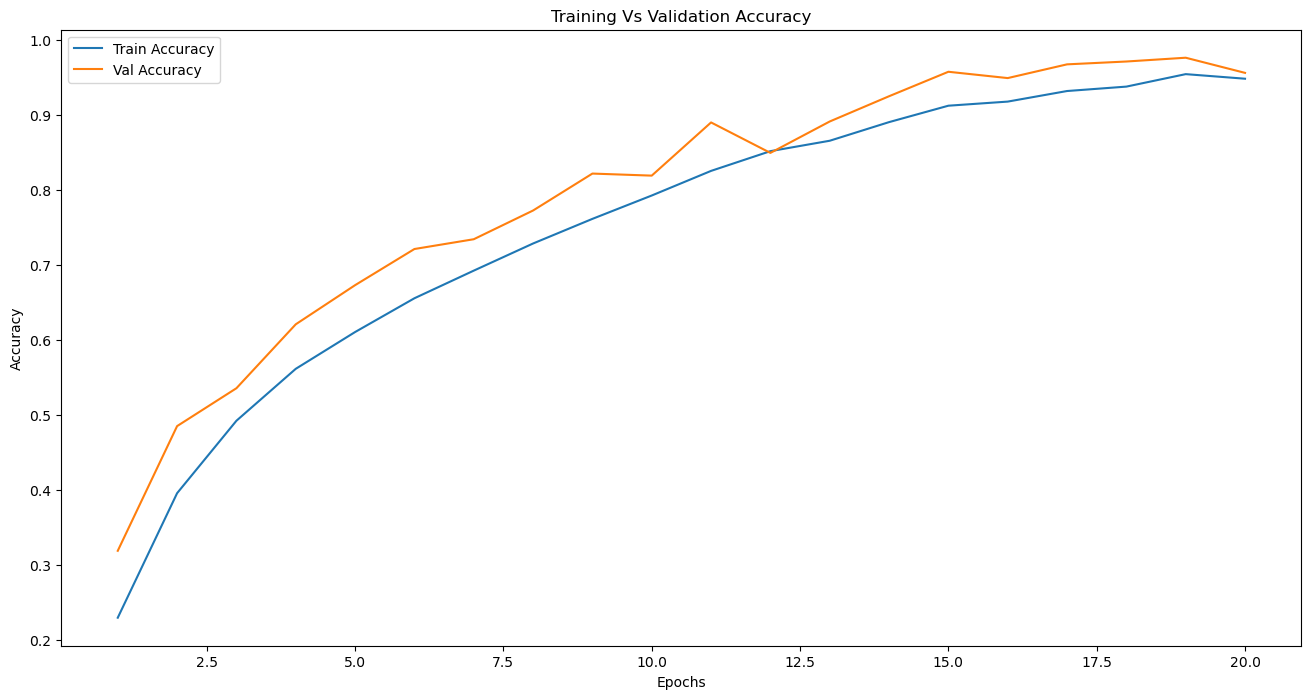

In [16]:
plot([train_loss,val_loss],['Train Loss','Val Loss'],'Epochs','Loss','Training Vs Validation Loss')
plot([train_acc,val_acc],['Train Accuracy','Val Accuracy'],'Epochs','Accuracy','Training Vs Validation Accuracy')

In [17]:
sample = val_dataset.dataset.data[0]

In [18]:
img = cv2.imread(sample['image_path'])
img = cv2.resize(img,(config.img_size))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0

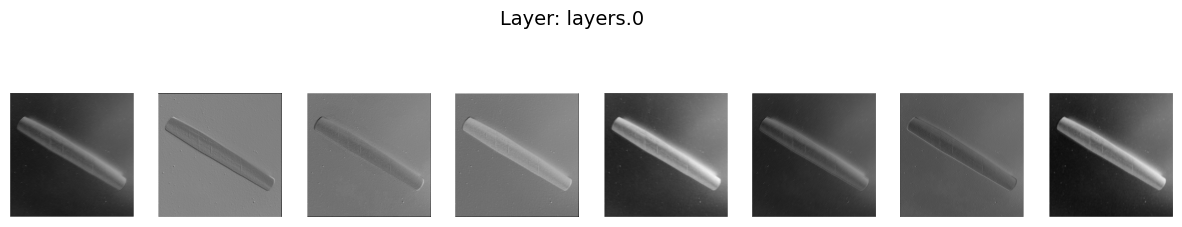

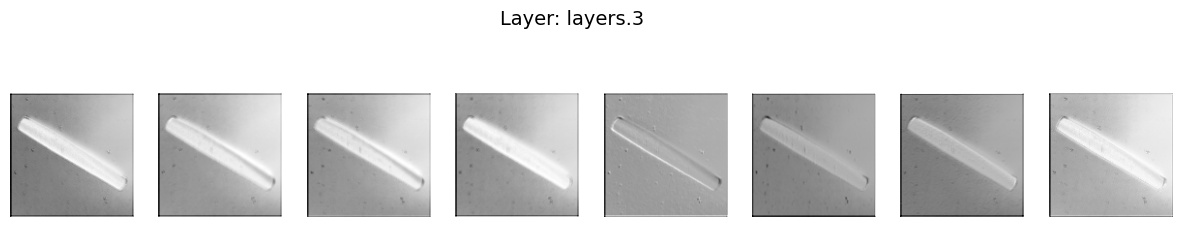

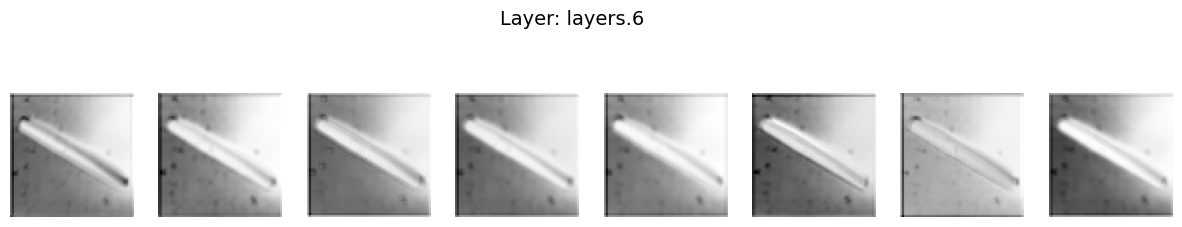

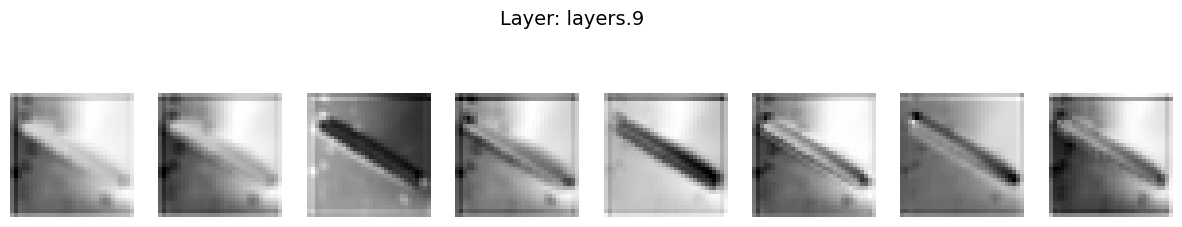

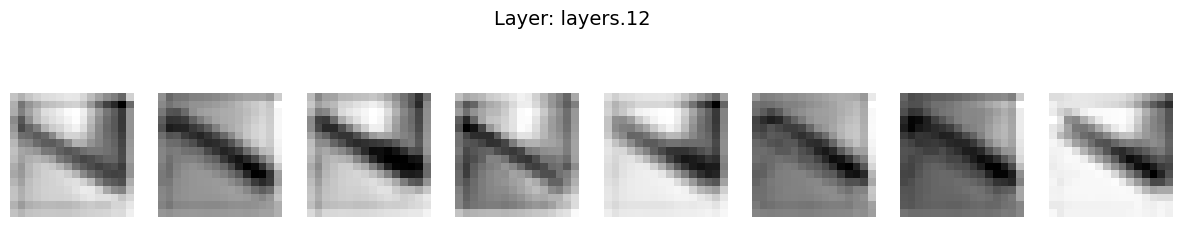

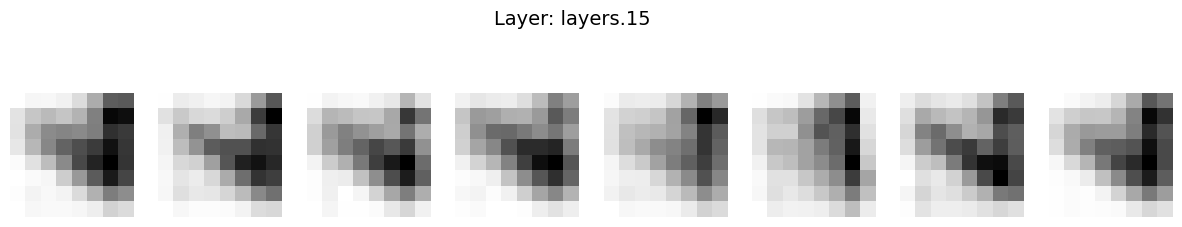

In [19]:
cnnmodel.backbone.visualize(img)

In [27]:
classical_config = Config()
classical_config.conv_hidden_dim=1 # This is to adjust the amount of downsampling

In [28]:
classical = ClassicalFeatureExtractor(classical_config)

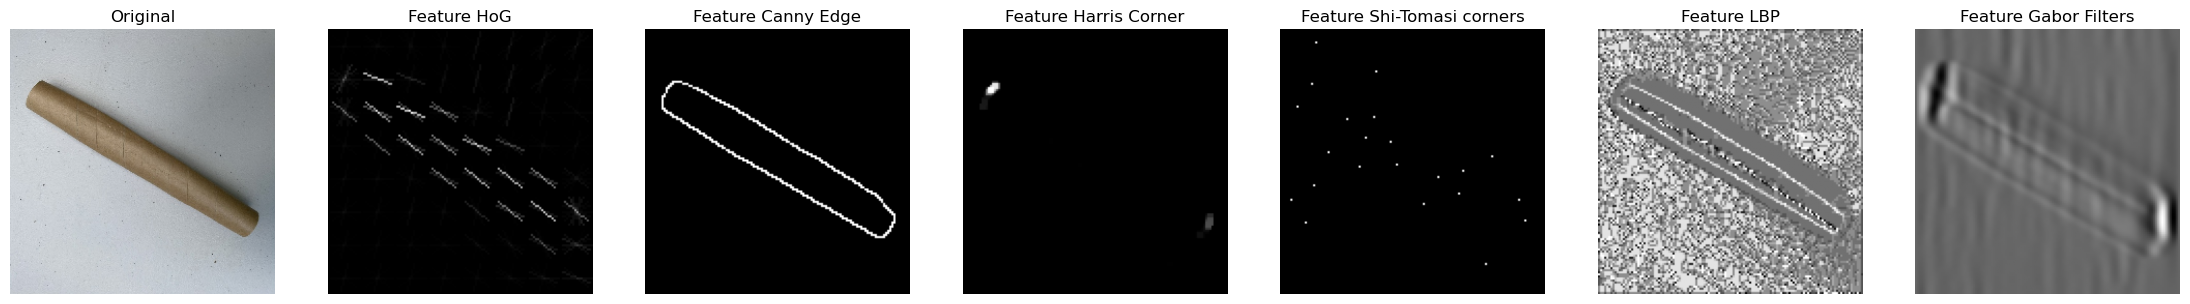

In [29]:
classical.visualize(img)

In [30]:
classic_model = Classifier(classical,train_dataset.dataset.classes,classical_config).to(device)

In [31]:
classic_trainer = RealWasteTrainer(classic_model,train_dataset.dataset,val_dataset.dataset,batch_size=BATCH_SIZE,lr=1e-3,device=device)

In [32]:
start_time = time.time()

Epoch 1 Train Loss: 1.9466 | Train Acc : 0.2938 | Val Loss : 1.5727 | Val Acc : 0.4093


Epoch 2 Train Loss: 1.5535 | Train Acc : 0.4236 | Val Loss : 1.3496 | Val Acc : 0.5112


Epoch 3 Train Loss: 1.3681 | Train Acc : 0.5044 | Val Loss : 1.2246 | Val Acc : 0.5436


Epoch 4 Train Loss: 1.2358 | Train Acc : 0.5499 | Val Loss : 1.0398 | Val Acc : 0.6498


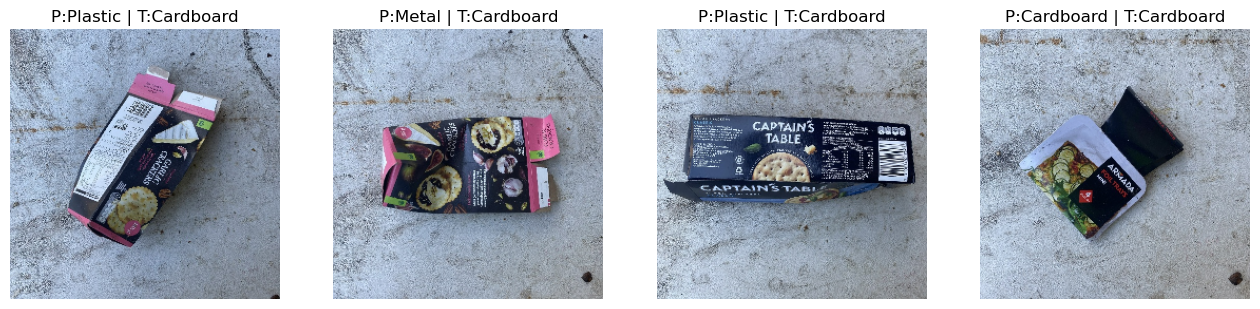

Epoch 5 Train Loss: 1.0686 | Train Acc : 0.6191 | Val Loss : 0.9175 | Val Acc : 0.6780


Epoch 6 Train Loss: 0.8651 | Train Acc : 0.6944 | Val Loss : 0.7687 | Val Acc : 0.7346


Epoch 7 Train Loss: 0.7132 | Train Acc : 0.7443 | Val Loss : 0.5947 | Val Acc : 0.7675


Epoch 8 Train Loss: 0.5660 | Train Acc : 0.7963 | Val Loss : 0.4553 | Val Acc : 0.8502


Epoch 9 Train Loss: 0.4329 | Train Acc : 0.8489 | Val Loss : 0.2905 | Val Acc : 0.8939


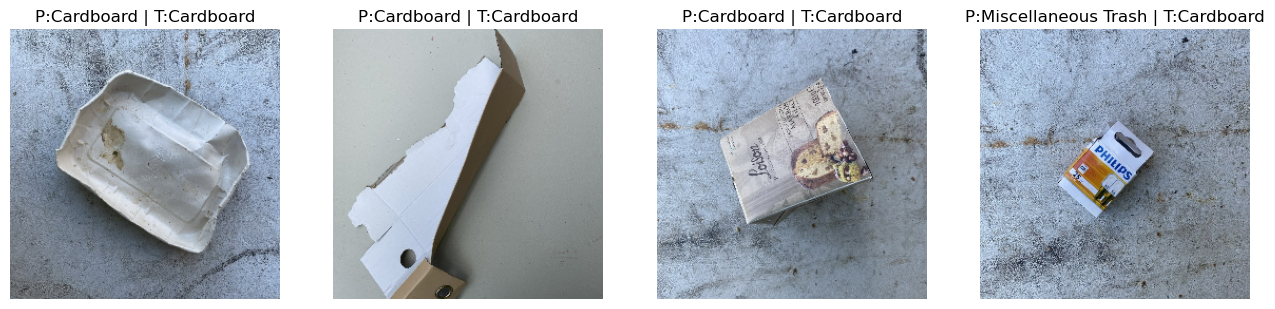

Epoch 10 Train Loss: 0.2915 | Train Acc : 0.8998 | Val Loss : 0.1450 | Val Acc : 0.9550


Epoch 11 Train Loss: 0.2694 | Train Acc : 0.9070 | Val Loss : 0.2079 | Val Acc : 0.9299


Epoch 12 Train Loss: 0.2565 | Train Acc : 0.9162 | Val Loss : 0.0847 | Val Acc : 0.9716


Epoch 13 Train Loss: 0.0991 | Train Acc : 0.9665 | Val Loss : 0.0678 | Val Acc : 0.9798


Epoch 14 Train Loss: 0.0885 | Train Acc : 0.9697 | Val Loss : 0.5937 | Val Acc : 0.8283


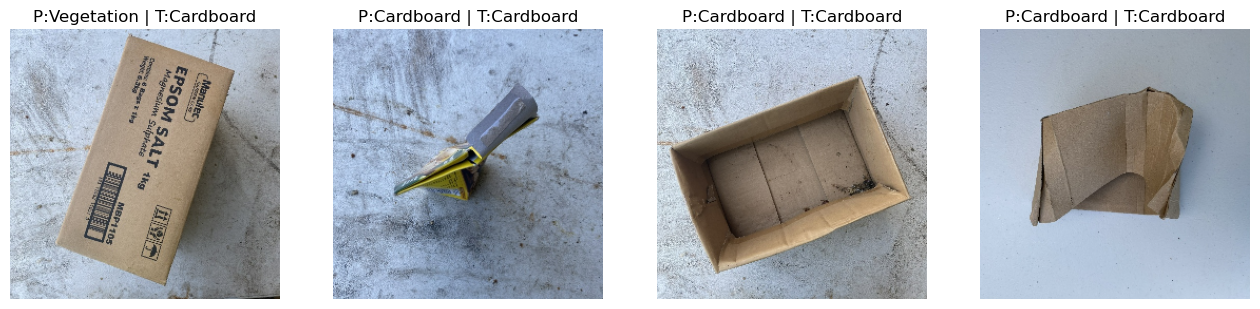

Epoch 15 Train Loss: 0.1965 | Train Acc : 0.9350 | Val Loss : 0.1995 | Val Acc : 0.9354


Epoch 16 Train Loss: 0.0721 | Train Acc : 0.9760 | Val Loss : 0.0306 | Val Acc : 0.9905


Epoch 17 Train Loss: 0.1796 | Train Acc : 0.9419 | Val Loss : 0.1391 | Val Acc : 0.9514


Epoch 18 Train Loss: 0.1085 | Train Acc : 0.9611 | Val Loss : 0.0839 | Val Acc : 0.9724


Epoch 19 Train Loss: 0.0190 | Train Acc : 0.9952 | Val Loss : 0.0049 | Val Acc : 0.9996


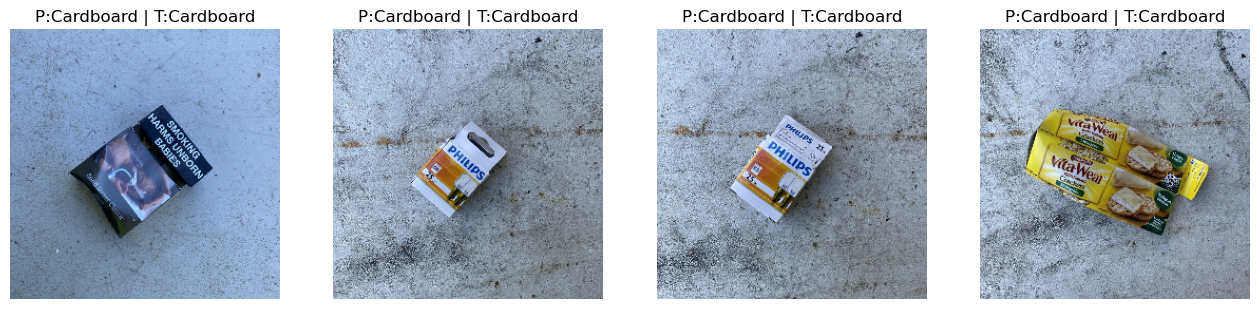

Epoch 20 Train Loss: 0.0063 | Train Acc : 0.9987 | Val Loss : 0.0042 | Val Acc : 0.9987


In [33]:
train_loss,train_acc,val_loss,val_acc = classic_trainer.train(20,visualize_every=5)

In [34]:
dt = time.time()-start_time
print(f"Training took {dt} seconds")

Training took 2148.2719292640686 seconds


In [35]:
classic_model.save(os.path.join('trained_model','classic_model.pt'))

Model saved to trained_model\classic_model.pt


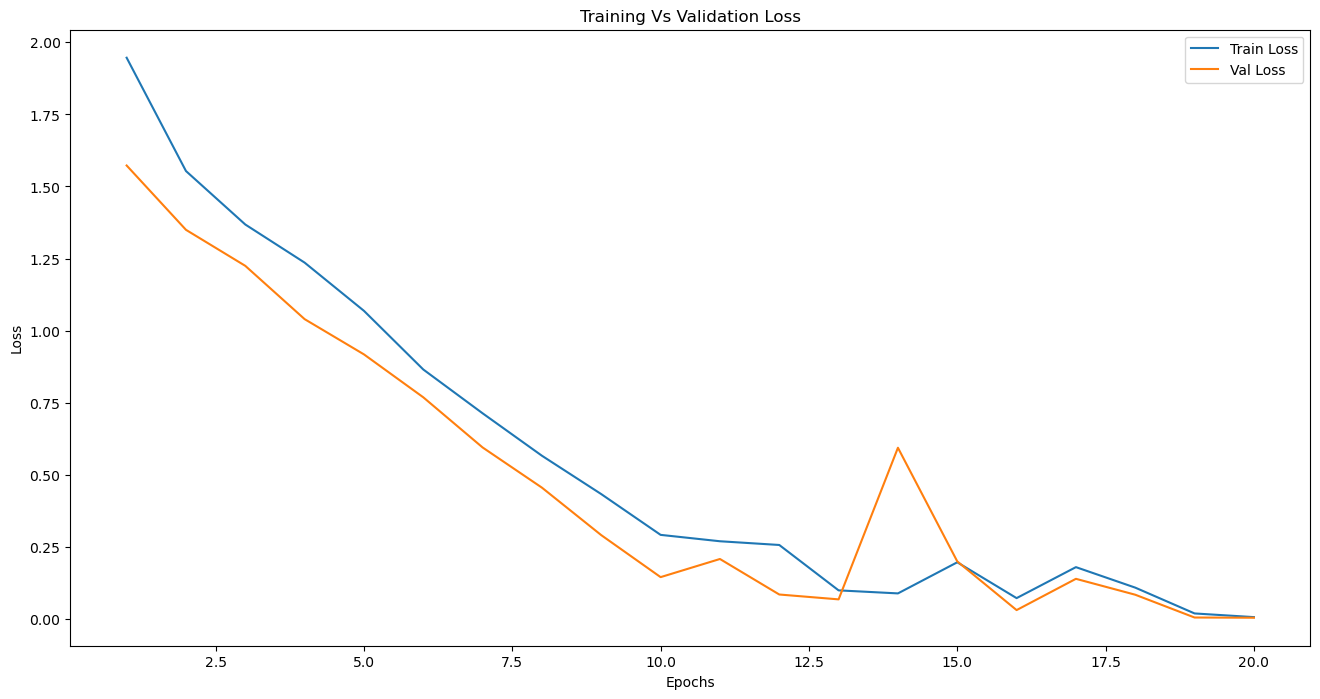

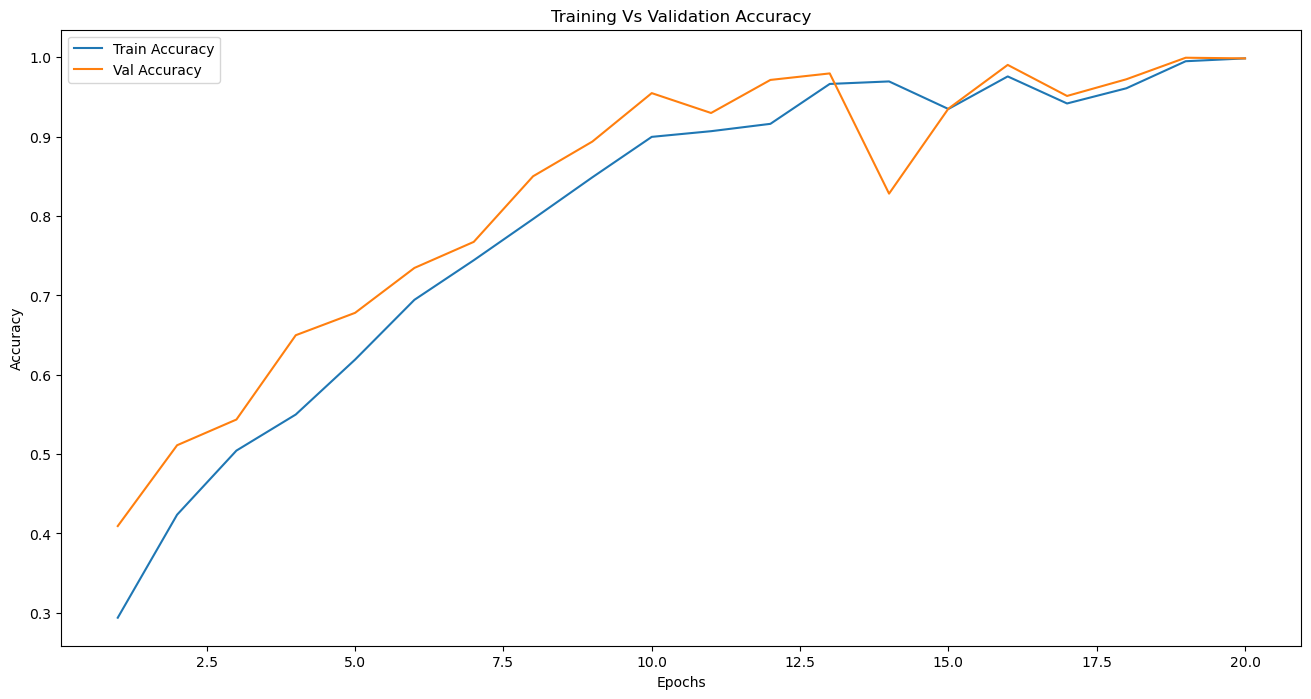

In [36]:
plot([train_loss,val_loss],['Train Loss','Val Loss'],'Epochs','Loss','Training Vs Validation Loss')
plot([train_acc,val_acc],['Train Accuracy','Val Accuracy'],'Epochs','Accuracy','Training Vs Validation Accuracy')